In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.rcParams['savefig.dpi'] = 250
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

In [3]:
! mkdir -p figures
! mkdir -p data

### Assert metadata values

In [4]:
MAIN=pd.read_table('./ChIP_ENA_table.tsv')
assert (MAIN['library_layout']   == 'SINGLE').all()
assert (MAIN['scientific_name']  == 'Mus musculus').all()
assert (MAIN['library_strategy'] == 'ChIP-Seq').all()
assert (MAIN['study_accession']  == 'PRJNA208439').all()
DF = MAIN[['run_accession','experiment_title']].sort_values('run_accession').reset_index(drop=True)
assert DF['experiment_title'].is_unique and DF['run_accession'].is_unique

### Separate metadata cols and clean 

In [5]:
# split the SAMPLE_ID field
DF['SAMPLE_ID'] = DF['experiment_title'].str.split().str[5]
assert DF['SAMPLE_ID'].is_unique
DF['TARGET']    = DF['SAMPLE_ID'].str.extract(r'(H3K4me1|H3K4me3|H3K27ac|H3K36me3|H3K27me3|RNAP_Ser5_Phos|WCE)')
DF['CELL_TYPE'] = DF['SAMPLE_ID'].str.extract(r'(ESC|MES|CP|CM)')
DF['REP']       = DF['SAMPLE_ID'].str.extract(r'(Rep_\d+)')
DF['REP']       = DF['REP'].str.extract(r'(\d+)')
assert DF.isna().any().sum() == 0
# modify the format
DF['TARGET']        = DF['TARGET'].replace('RNAP_Ser5_Phos', 'RNAPS5P')
DF['OLD_SAMPLE_ID'] = DF['SAMPLE_ID']
DF['SUFFIX']        = 'Wamstad_2013_SE'
DF['SAMPLE_ID']     = DF['TARGET'].str.cat(DF[['CELL_TYPE','REP','SUFFIX']].values,sep='_')
DF['SAMPLE_ID_SHORT'] = DF['TARGET'].str.cat(DF[['CELL_TYPE','REP']].values,sep='_')

### Keep only the first 2 replicates per combination

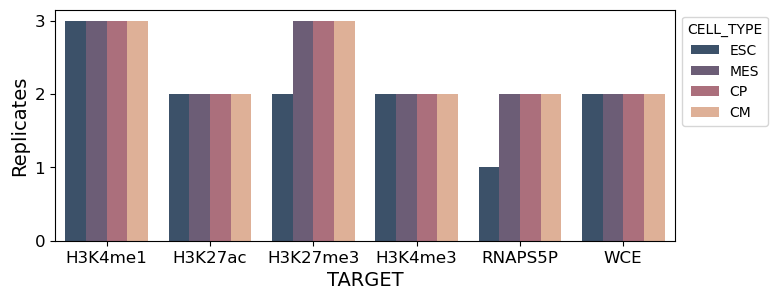

In [6]:
CT_COL_DICT = {'ESC': '#355070', 'MES': '#6d597a', 'CP': '#b56576','CM': '#eaac8b'}

plt.figure(figsize=(8,3))
ax = sns.countplot(data=DF,hue='CELL_TYPE',x='TARGET',palette=CT_COL_DICT)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Replicates')
plt.savefig(f'./figures/ChIP_REP_countplot_CT_HM.pdf', format="pdf", bbox_inches="tight")



In [7]:
DF = DF.sort_values(['TARGET','CELL_TYPE','REP'])
DF['REMOVED'] = False
c_R=1
old_T=''
old_C=''
for i, row in DF.iterrows():
    T,C,R = row['TARGET'],row['CELL_TYPE'],row['REP']
    if T == old_T and C == old_C: c_R += 1
    else:                         c_R  = 1
    if c_R > 2: DF.at[i,'REMOVED'] = True
    #print(T,C,R,row['REMOVED'])
    old_T, old_C = T,C
DF = DF.sort_values('run_accession')


In [8]:
DF[DF['REMOVED']==True][['SAMPLE_ID']]

,SAMPLE_ID
2,H3K4me1_ESC_3_Wamstad_2013_SE
5,H3K4me1_MES_3_Wamstad_2013_SE
8,H3K4me1_CP_3_Wamstad_2013_SE
11,H3K4me1_CM_3_Wamstad_2013_SE
24,H3K27me3_MES_3_Wamstad_2013_SE
27,H3K27me3_CP_3_Wamstad_2013_SE
30,H3K27me3_CM_3_Wamstad_2013_SE


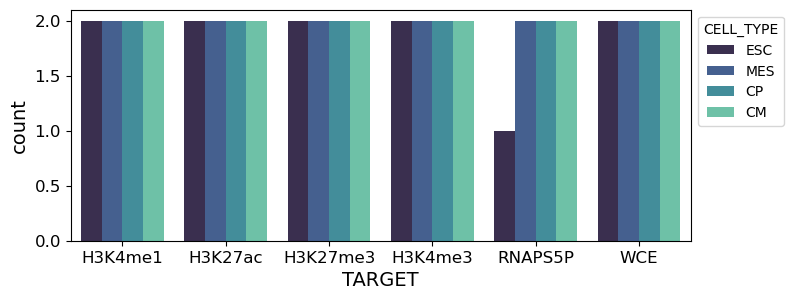

In [9]:
plt.figure(figsize=(8,3))
ax = sns.countplot(data=DF[DF['REMOVED'] == False],hue='CELL_TYPE',x='TARGET',palette='mako')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(f'./figures/ChIP_REP_countplot_CT_HM_AFTER.pdf', format="pdf", bbox_inches="tight")

In [10]:
CHIP_TABLE=DF[DF['REMOVED'] == False][['run_accession', 'SAMPLE_ID', 'TARGET', 'CELL_TYPE',
                                    'REP', 'OLD_SAMPLE_ID','SAMPLE_ID_SHORT']]

#### FILE_NAMES and TABLE (w/o RNAP5SP and H3K4me1)

In [11]:
#RNA5PS5P
CHIP_TABLE[CHIP_TABLE['TARGET']=='RNAPS5P'].to_csv(             './data/ChIP_RNAPS5P.csv',index=False)
CHIP_TABLE[CHIP_TABLE['TARGET']=='RNAPS5P']['SAMPLE_ID'].to_csv('./data/FILE_NAMES_RNAPS5P.list',index=False,header=False)

In [12]:
#Narrow
CHIP_TABLE[~CHIP_TABLE['TARGET'].isin(['RNAPS5P', 'H3K4me1'])].to_csv(             './data/ChIP_NARROW.csv',index=False)
CHIP_TABLE[~CHIP_TABLE['TARGET'].isin(['RNAPS5P', 'H3K4me1'])]['SAMPLE_ID'].to_csv('./data/FILE_NAMES_NARROW.list',index=False,header=False)

In [13]:
CHIP_TABLE

,run_accession,SAMPLE_ID,TARGET,CELL_TYPE,REP,OLD_SAMPLE_ID,SAMPLE_ID_SHORT
0,SRR900935,H3K4me1_ESC_1_Wamstad_2013_SE,H3K4me1,ESC,1,H3K4me1_ESC_Rep_1,H3K4me1_ESC_1
1,SRR900936,H3K4me1_ESC_2_Wamstad_2013_SE,H3K4me1,ESC,2,H3K4me1_ESC_Rep_2,H3K4me1_ESC_2
3,SRR900938,H3K4me1_MES_1_Wamstad_2013_SE,H3K4me1,MES,1,H3K4me1_MES_Rep_1,H3K4me1_MES_1
4,SRR900939,H3K4me1_MES_2_Wamstad_2013_SE,H3K4me1,MES,2,H3K4me1_MES_Rep_2,H3K4me1_MES_2
6,SRR900941,H3K4me1_CP_1_Wamstad_2013_SE,H3K4me1,CP,1,H3K4me1_CP_Rep_1,H3K4me1_CP_1
7,SRR900942,H3K4me1_CP_2_Wamstad_2013_SE,H3K4me1,CP,2,H3K4me1_CP_Rep_2,H3K4me1_CP_2
9,SRR900944,H3K4me1_CM_1_Wamstad_2013_SE,H3K4me1,CM,1,H3K4me1_CM_Rep_1,H3K4me1_CM_1
10,SRR900945,H3K4me1_CM_2_Wamstad_2013_SE,H3K4me1,CM,2,H3K4me1_CM_Rep_2,H3K4me1_CM_2
12,SRR900947,H3K27ac_ESC_1_Wamstad_2013_SE,H3K27ac,ESC,1,H3K27ac_ESC_Rep_1,H3K27ac_ESC_1
13,SRR900948,H3K27ac_ESC_2_Wamstad_2013_SE,H3K27ac,ESC,2,H3K27ac_ESC_Rep_2,H3K27ac_ESC_2
